## Extreme precipitation in the Third Pole region : GPM, MSWEP and CNRR 

In [150]:
import numpy as np
import os
import glob 
import random 

import matplotlib.pyplot as plt
import cartopy
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors

import scipy
from scipy import ndimage
from scipy.stats import skew
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt

from netCDF4 import Dataset
from collections import Counter 

import pandas as pd 

In [151]:
## import my own functions

from mcs_functions import *
filename='.........'

In [152]:
# This function creates a dictionary containing all hourly files within one month, keys are month for year and values are the corresponding files 
def create_dic():
    
    files={}
    keys=[]
    values=[]
    
    working_dir= '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/'
    
    for month in np.arange(1,13,1):
        if month < 10:
            keys.append('0'+str(month))
        else:
            keys.append(str(month))       

    for k in keys:
        values.append(glob.glob(working_dir + 'GPM_IMERG_????' + str(k) + '*cumprec*.nc4'))

    ## populate dictionary with keys and values 
    files= dict(zip(keys, values))

    return files 


In [153]:
# save daily all grid values for each month where rain rate > 1mm/day 
def extract_rain_rates(prec, rr):
    for idx, row in enumerate(prec):
        for x in row:
            if x >= 0.1:
                rr= np.append(rr, x)         
    return rr

In [154]:
# save daily all grid values for each month where rain rate > 1mm/day 
def eca_ptot(prec, total_rr, rr99, pp):
    for idx, row in enumerate(prec):
        for x in row:
            if x > 0:
                total_rr += x
                if x >= pp:
                    rr99 += x
    return total_rr, rr99

In [155]:
# dictionary with daily files for each month
files= create_dic()

## Extract elevations > 3000 m ASL 

In [156]:
# extract only values above 3000 m a.s.l. 
def read_in_netcdf_dem(file):
    dataset = Dataset(file)    
    dem= np.array(dataset["Band1"])
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    dataset.close()
    return dem, lon, lat

In [157]:
import xarray as xr
import xesmf as xe
# open netCDF file with xarray
ds = '/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_small.nc'
dem= xr.open_dataset(ds)
elevations = dem['Band1'].values
lat= dem['lat'].values
lon= dem['lon'].values

In [158]:
# output grid for resizing
lo= np.arange(70.05,105.05,0.1)
la= np.arange(26.95,44.95,0.1)
ds_out = xr.Dataset({'lat': (['lat'], la),'lon': (['lon'], lo),})

# resize elevation to 0.1 x 0.1 grid 
regridder = xe.Regridder(dem, ds_out, 'bilinear', reuse_weights=True)

Reuse existing file: bilinear_4800x8400_181x350.nc


In [159]:
dem_new = regridder(elevations) # regridder has been saved to current directory 
dem_new= np.hstack((dem_new,np.zeros((dem_new.shape[0],1))))
dem_new= dem_new.T

In [161]:
# resize to 0.1 x 0.1 grid for MSWEP dataset 
lo= np.arange(70.0, 110.2,0.1)
la= np.arange(25.0,45.2,0.1)
mswep_out= xr.Dataset({'lat': (['lat'], la),'lon': (['lon'], lo),})
regridder2 = xe.Regridder(dem, mswep_out, 'bilinear', reuse_weights=True)

Reuse existing file: bilinear_4800x8400_203x402.nc


In [162]:
dem_out = regridder2(elevations) # regridder has been saved to current directory 
dem_out =dem_out[:-1,:]

## GPM: monthly extreme precipitation 

In [ ]:
# main loop 
for month in files.keys():
    rr= np.empty([])
    for f in files[month]:
        prec, lons, lats, date, time= read_in_netcdf(f, filename)
        prec= prec[0,:]
        prec[dem_new < 3000 ]= 0
        rr= extract_rain_rates(prec, rr)
        
    # save parameter to text file after having looped through all daily files 
    np.savetxt('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/monthly_rr_' + month + '.csv', rr, delimiter=",")
    print('....files created with  ', np.shape(rr), '  values in month  ', month)

....files created with   (375349,)   values in month   01
....files created with   (461206,)   values in month   02
....files created with   (947749,)   values in month   03
....files created with   (1386382,)   values in month   04
....files created with   (1798403,)   values in month   05
....files created with   (2036633,)   values in month   06


In [93]:
# idea: look at seasonal distribution of consecutive wet days 

In [99]:
# read in created text files and calculate monthly 99-percentiles in each dataset 

from numpy import genfromtxt
percentiles = np.empty([])
all_values = np.empty([])

for month in files.keys():
    monthly_rr = genfromtxt('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/monthly_rr_' + month + '.csv', delimiter=',')
    all_values = np.append(all_values, monthly_rr)
    monthly_p= np.nanpercentile(monthly_rr, 99) 
    print(month, np.shape(monthly_rr), monthly_p)
    percentiles= np.append(percentiles, monthly_p)
    

# save parameter to text file after having looped through all daily files 
np.savetxt('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/monthly_percentiles.csv', percentiles, delimiter=",")

01 (22130,) 1.756273519992822
02 (24449,) 2.200775051116945
03 (38997,) 2.54816125869751
04 (46860,) 2.697986164093005
05 (53547,) 2.6791838026046753
06 (79527,) 2.9004856777191828
07 (86713,) 1.8299999237060547
08 (77602,) 2.078187499046326
09 (47417,) 2.5294931697845344
10 (22283,) 2.093387999534608
11 (11986,) 2.631332898139948
12 (13155,) 1.7453305816650386


In [100]:
# calculate percentage of precipitation above 99th percentile in relation to total average precipitation during month

percentages= np.empty([])
i= 1 

for month in files.keys():
    print('....calculating ecaptot for month   ',month)
    total_rr= 0 
    rr99= 0 
    for f in files[month]:
        prec, lons, lats, date, time= read_in_netcdf(f, filename)
        prec[dem_new < 3000 ]= np.nan
        pp = percentiles[i]
        total_rr, rr99= eca_ptot(prec, total_rr, rr99, pp)
    i+= 1
    ecaptot= np.divide(rr99, total_rr)*100
    percentages= np.append(percentages, ecaptot)
    
# save parameter to text file after having looped through all daily files 
np.savetxt('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/monthly_ecaptot.csv', percentages, delimiter=",")

....calculating ecaptot for month    01
....calculating ecaptot for month    02
....calculating ecaptot for month    03
....calculating ecaptot for month    04
....calculating ecaptot for month    05
....calculating ecaptot for month    06
....calculating ecaptot for month    07
....calculating ecaptot for month    08
....calculating ecaptot for month    09
....calculating ecaptot for month    10
....calculating ecaptot for month    11
....calculating ecaptot for month    12


## Plots : Extreme precipitation in different precip datasets for the TP 

In [ ]:
## read in created files for GPM, MSWEP, CNRR and ERA50 
# data = genfromtxt(path, delimiter=',')

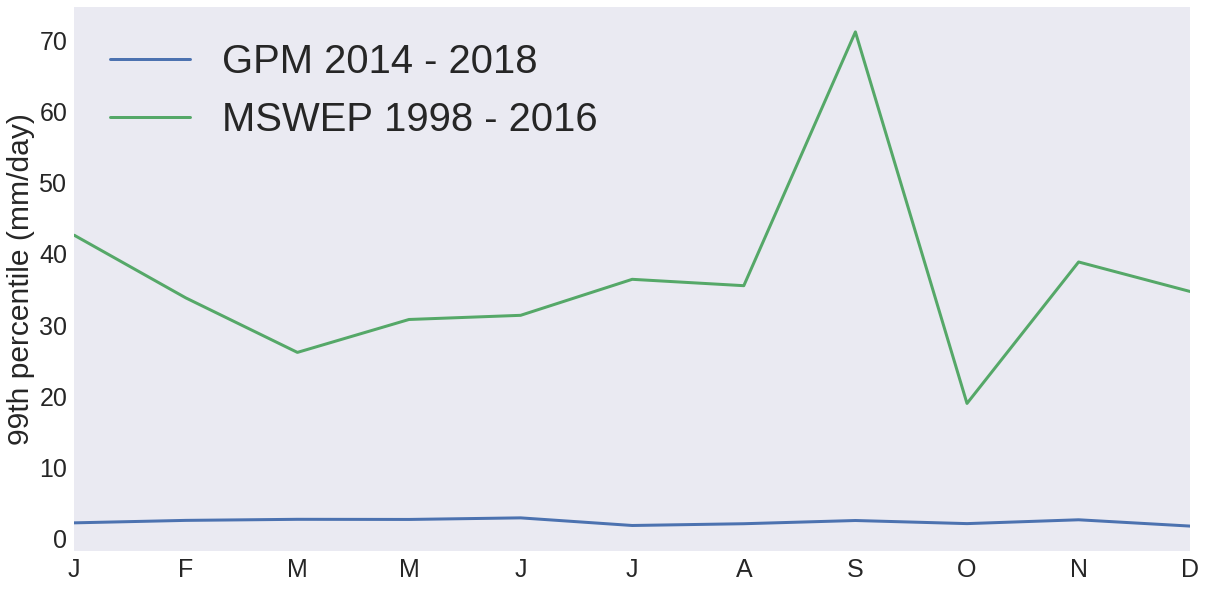

<Figure size 576x396 with 0 Axes>

In [126]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(20, 10))
plt.ylabel('99th percentile (mm/day)', fontsize= 30)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.grid()
plt.xlim(1,11)
plt.plot(percentiles[1::], linewidth= '3', label='GPM 2014 - 2018')
plt.plot(percentiles_mswep[1::], linewidth= '3', label= 'MSWEP 1998 - 2016')
plt.legend( prop={'size': 40})
plt.show()
plt.rcParams.update({'font.size': 30})


plt.savefig('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tracks/plots/gpm_mswep19982016_extremeprecip_percentiles.png')



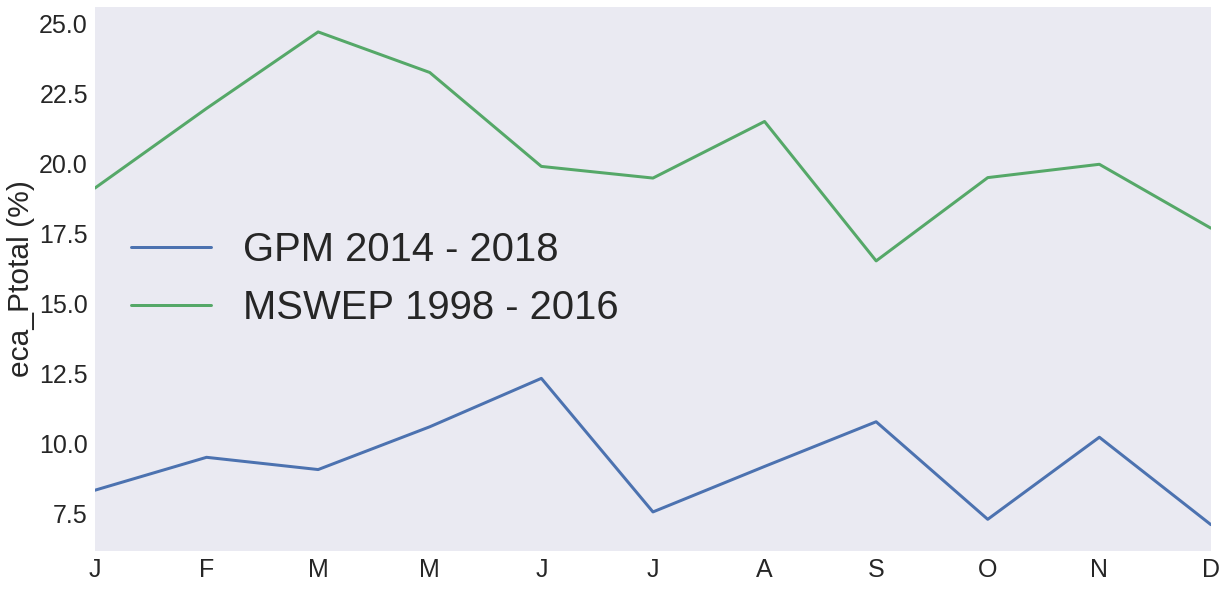

<Figure size 576x396 with 0 Axes>

In [127]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(20, 10))
plt.ylabel('eca_Ptotal (%)', fontsize= 30)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.grid()
plt.xlim(1,11)
plt.plot(percentages[1::], linewidth= '3', label='GPM 2014 - 2018')
plt.plot(mswep_percentages[1::], linewidth= '3', label= 'MSWEP 1998 - 2016')
plt.legend( prop={'size': 40})
plt.show()
plt.rcParams.update({'font.size': 30})


plt.savefig('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tracks/plots/gpm_mswep19982016_extremeprecip_ecaptot.png')


## Grid plot GPM

In [506]:
# read in grid with 99th percentile (all year)

file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/prec99_summer.nc4'
filename= 'prec99_summer.nc4'
prec, lons, lats, date, time= read_in_netcdf(file, filename)
prec90=  prec[0,:]

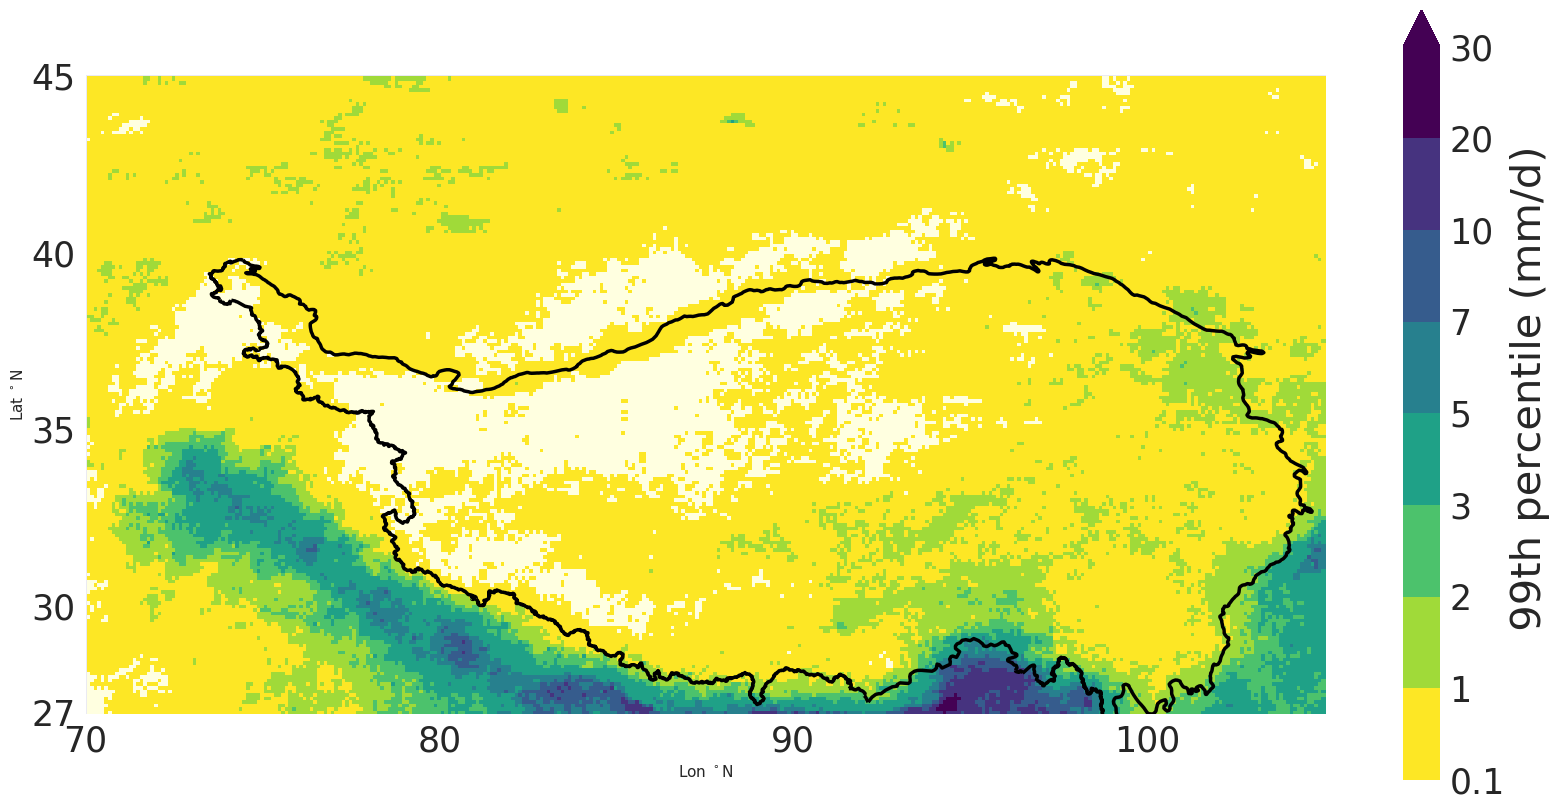

In [510]:
plt.figure(figsize=(20, 10))

cmap = plt.cm.get_cmap('viridis_r')
bounds= np.array([0.1, 1 , 2, 3, 5, 7, 10, 20, 30])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)

m = Basemap(projection='cyl', llcrnrlat=26.95,urcrnrlat=44.95, llcrnrlon=70.05, urcrnrlon=105.05,  resolution = 'c')
#m = Basemap(width=4000000,height=3000000,resolution='l', projection='aea',lat_1=27.,lat_2=45,lon_0=90, lat_0= (45+27)/2)

lon, lat =np.meshgrid(lons[:,0], lats[0,:])
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec90.T, cmap=cmap, norm = norm, vmin= 0.1, vmax = 30 )
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N')
plt.ylabel('Lat $^\circ$N')

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


cbar = plt.colorbar(extend= 'max')
cbar.set_label(' 99th percentile (mm/d)', fontsize= 30)
cbar.set_ticks(bounds)
labels = ['0.1', '1', '2', '3', '5', '7', '10', '20', '30']
cbar.set_ticklabels(labels)

plt.rcParams.update({'font.size': 25})


plt.savefig('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tracks/plots/gpm_extremeprecip_percentiles_grid.png')


## MSWEP grid plot

In [30]:
def read_in_netcdf_mswep(file):
    dataset = Dataset(file)    
    prec= np.array(dataset["precipitation"])
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    dataset.close()
    return prec, lon, lat
    

In [142]:
# read in grid with 99th percentile (all year)

file = '/media/juli/Elements/MSWEP/MSWEP/daily/prec99_summer.nc'
prec, lons, lats = read_in_netcdf_mswep(file)
prec99= prec[0,:]


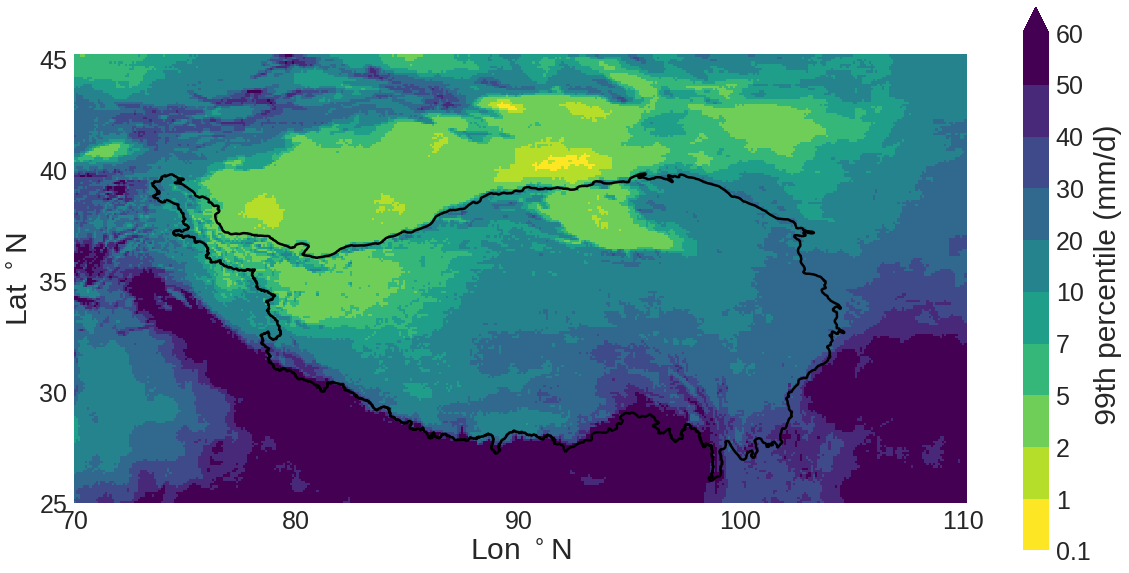

In [143]:
plt.figure(figsize=(20, 10))

cmap = plt.cm.get_cmap('viridis_r')
bounds= np.array([ 0.1, 1,2,  5, 7, 10, 20, 30, 40, 50, 60])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)

m = Basemap(projection='cyl', llcrnrlat=25,urcrnrlat=45.2, llcrnrlon=70, urcrnrlon=110.2,  resolution = 'c')
#m = Basemap(width=4000000,height=3000000,resolution='l', projection='aea',lat_1=27.,lat_2=45,lon_0=90, lat_0= (45+27)/2)

lon, lat =np.meshgrid(lons, lats)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec99, cmap=cmap, norm = norm, vmin= 0.1, vmax = 60)
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100, 110]
ylabels= [ 25, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100, 110], xlabels, fontsize=25)
plt.yticks([25,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N', fontsize= 30)
plt.ylabel('Lat $^\circ$N', fontsize= 30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


cbar = plt.colorbar(extend= 'max')
cbar.set_label(' 99th percentile (mm/d)', fontsize= 30
              )
cbar.set_ticks(bounds)
labels = ['0.1','1', '2', '5', '7', '10', '20', '30', '40', '50', '60']
cbar.set_ticklabels(labels)

plt.rcParams.update({'font.size': 25})


plt.savefig('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_extremeprecip_percentiles_grid.png')


## MSWEP: Monthly extreme precipitation 

In [120]:
# This function creates a dictionary containing all hourly files within one month, keys are month for year and values are the corresponding files 
def create_dic():  
    files={}
    keys=[]
    values=[]
    working_dir= '/media/juli/Elements/MSWEP/MSWEP/daily/'
    
    for month in np.arange(1,13,1):
        if month < 10:
            keys.append('0'+str(month))
        else:
            keys.append(str(month))       

    for k in keys:
        for r in np.arange(1998,2016,1):
            values.append(glob.glob(working_dir + 'MSWEP_' + str(r) + str(k) + '*daily_acc*.nc'))
        #values.append(glob.glob(working_dir + 'MSWEP_2014' + str(k) + '*daily_acc*.nc'))
        #values.append(glob.glob(working_dir + 'MSWEP_2015' + str(k) + '*daily_acc*.nc'))
        #values.append(glob.glob(working_dir + 'MSWEP_2016' + str(k) + '*daily_acc*.nc'))

    ## populate dictionary with keys and values 
    files= dict(zip(keys, values))
    mswep = files 
    return mswep

In [121]:
mswep= create_dic()

{'01': ['/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_19980101_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_19980103_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_19980104_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_19980105_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_19980106_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_19980107_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_19980108_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_19980109_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_19980110_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_19980111_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_19980112_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_19980113_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_19980114_daily_acc_pre

In [122]:
# main loop to create files with monthly rain rate values 
for month in mswep.keys():
    rr= np.empty([])
    for f in mswep[month]:
        prec, lons, lats = read_in_netcdf_mswep(f)
        prec = prec[0,:]
        prec[dem_out < 3000 ]= 0
        rr= extract_rain_rates(prec, rr)
        
    # save parameter to text file after having looped through all daily files 
    np.savetxt('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_monthly_rr_' + month + '1998_2016.csv', rr, delimiter=",")
    print('....files created with  ', np.shape(rr), '  values in month  ', month)

....files created with   (104184,)   values in month   01
....files created with   (83538,)   values in month   02
....files created with   (147180,)   values in month   03
....files created with   (98850,)   values in month   04
....files created with   (164016,)   values in month   05
....files created with   (74472,)   values in month   06
....files created with   (142009,)   values in month   07
....files created with   (135823,)   values in month   08
....files created with   (97382,)   values in month   09
....files created with   (45468,)   values in month   10
....files created with   (175624,)   values in month   11
....files created with   (91671,)   values in month   12


In [123]:
# read in created text files and calculate monthly 99-percentiles in each dataset 

percentiles_mswep = np.empty([])
all_values_mswep = np.empty([])

for month in files.keys():
    monthly_rr = genfromtxt('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_monthly_rr_' + month + '1998_2016.csv', delimiter=',')
    all_values_mswep = np.append(all_values_mswep, monthly_rr)
    monthly_p= np.nanpercentile(monthly_rr, 99) 
    print(month, np.shape(monthly_rr), monthly_p)
    percentiles_mswep= np.append(percentiles_mswep, monthly_p)
    
# save parameter to text file after having looped through all daily files 
np.savetxt('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_monthly_percentiles_1998_2016.csv', percentiles, delimiter=",")

01 (104184,) 38.441698989868144
02 (83538,) 42.617798881531044
03 (147180,) 33.80999835968017
04 (98850,) 26.149999618530273
05 (164016,) 30.775500583648856
06 (74472,) 31.360000610351562
07 (142009,) 36.419198303222785
08 (135823,) 35.52339904785153
09 (97382,) 71.1819007110596
10 (45468,) 18.979999542236328
11 (175624,) 38.85540050506571
12 (91671,) 34.70600090026861


In [124]:
# calculate percentage of precipitation above 99th percentile in relation to total average precipitation during month

mswep_percentages= np.empty([])
i= 1

for month in mswep.keys():
    print('....calculating ecaptot for month   ',month)
    total_rr= 0 
    rr99= 0 
    for f in mswep[month]:
        prec, lons, lats= read_in_netcdf_mswep(f)
        prec= prec[0,:]
        prec[dem_out < 3000 ]= 0
        pp = percentiles_mswep[i]
        total_rr, rr99= eca_ptot(prec, total_rr, rr99, pp)
    i+= 1
    ecaptot= np.divide(rr99, total_rr)*100
    mswep_percentages= np.append(mswep_percentages, ecaptot)
    
# save parameter to text file after having looped through all daily files 
np.savetxt('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_monthly_ecaptot_1998_2016.csv', mswep_percentages, delimiter=",")

....calculating ecaptot for month    01
....calculating ecaptot for month    02
....calculating ecaptot for month    03
....calculating ecaptot for month    04
....calculating ecaptot for month    05
....calculating ecaptot for month    06
....calculating ecaptot for month    07
....calculating ecaptot for month    08
....calculating ecaptot for month    09
....calculating ecaptot for month    10
....calculating ecaptot for month    11
....calculating ecaptot for month    12


## DISTRIBUTION OF RAIN RATES IN THE DIFFERENT DATA SETS 

In [131]:
# distribution MSWEP 

mswep_dist= np.empty([])

for month in mswep.keys():
    print('...read in all values for month ', month)
    data = genfromtxt('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_monthly_rr_' + month + '1998_2016.csv', delimiter=',')
    mswep_dist= np.append(mswep_dist, data)


...read in all values for month  01
...read in all values for month  02
...read in all values for month  03
...read in all values for month  04
...read in all values for month  05
...read in all values for month  06
...read in all values for month  07
...read in all values for month  08
...read in all values for month  09
...read in all values for month  10
...read in all values for month  11
...read in all values for month  12


In [62]:
# distribution GPM 

gpm_dist = np.empty([])

for month in files.keys():
    print('...read in all values for month ', month)
    data = genfromtxt('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/monthly_rr_' + month + '.csv', delimiter=',')
    gpm_dist= np.append(gpm_dist, data)

...read in all values for month  01
...read in all values for month  02
...read in all values for month  03
...read in all values for month  04
...read in all values for month  05
...read in all values for month  06
...read in all values for month  07
...read in all values for month  08
...read in all values for month  09
...read in all values for month  10
...read in all values for month  11
...read in all values for month  12


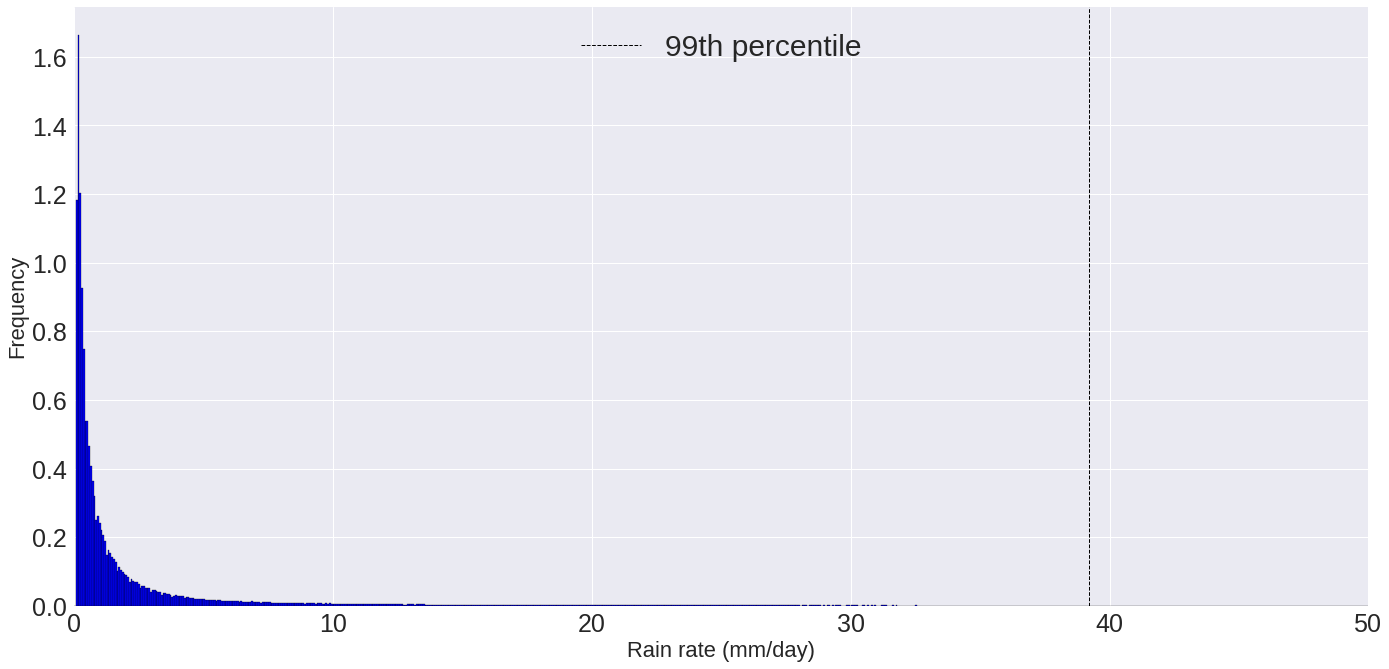

<Figure size 576x396 with 0 Axes>

In [134]:
import seaborn as sns

plt.figure(figsize=(20, 10))

binwidth= 0.05
# Draw the plot
plt.hist(mswep_dist, bins = int(180/binwidth),
         color = 'blue', edgecolor = 'black', density=True)

# Title and labels
#plt.title('MSWEP rain rate distribution', fontsize= 40)
plt.xlabel('Rain rate (mm/day)', size = 22)
plt.ylabel('Frequency', size= 22)
plt.xlim(0,50)

plt.axvline(p_mswep, color='k', linestyle='dashed', linewidth=1, label = '99th percentile')
plt.legend( loc = 'upper center', prop={'size': 30})

plt.tight_layout()
plt.show()


plt.savefig('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_distribution_1998_2016.png')

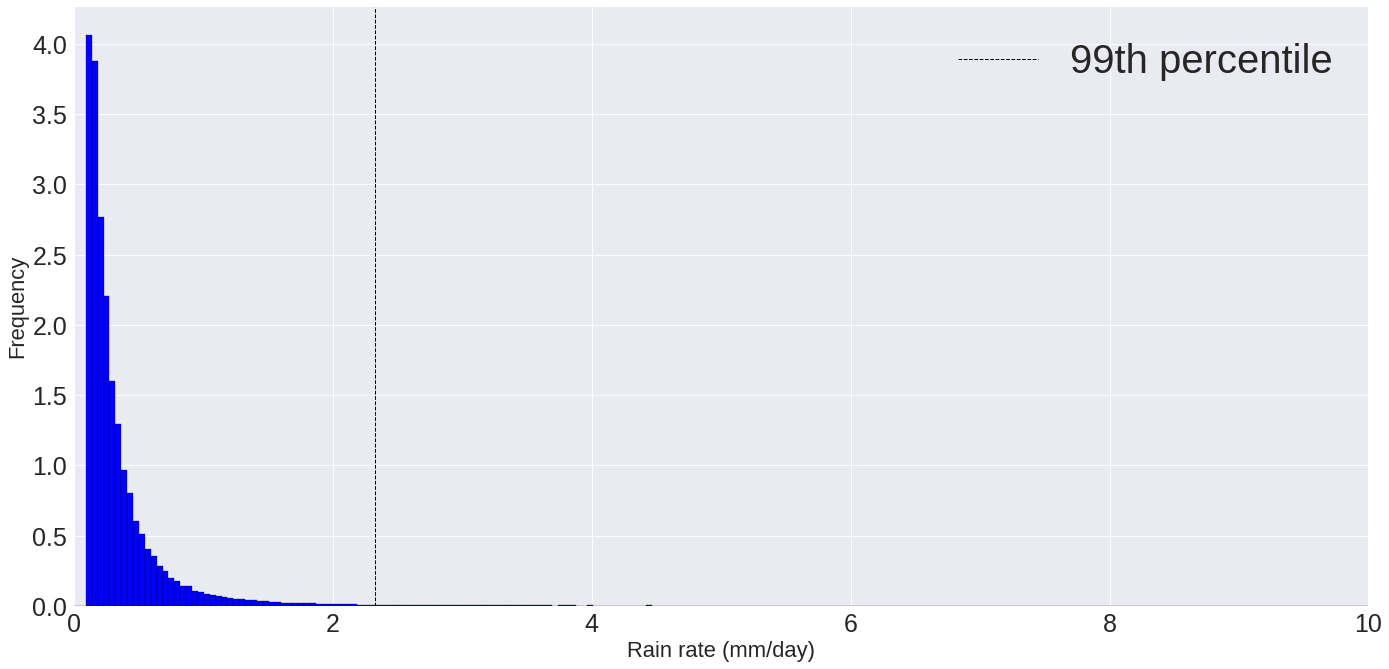

<Figure size 576x396 with 0 Axes>

In [130]:
plt.figure(figsize=(20, 10))

# Draw the plot
binwidth= 0.5
plt.hist(gpm_dist, bins = int(180/binwidth),
         color = 'blue', edgecolor = 'black', density=True)

plt.axvline(p_gpm, color='k', linestyle='dashed', linewidth=1, label = '99th percentile')
plt.legend( prop={'size': 40})

#plt.title('GPM rain rate distribution', fontsize= 30)

plt.xlabel('Rain rate (mm/day)', size = 22)
plt.ylabel('Frequency', size= 22)
plt.xlim(0,10)


plt.tight_layout()
plt.show()


plt.savefig('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tracks/plots/gpm_distribution.png')


In [104]:
p_gpm= np.nanpercentile(all_values, 99)
p_gpm

2.3281003332137997

In [133]:
p_mswep = np.nanpercentile(all_values_mswep, 99)
p_mswep

39.220001220703125

##  Why such a big difference in extreme values between GPM and MSWEP? 

- compare to CNRR, ERA5, CMORPH and stations to get an idea which one is closer 
- look at distributions from hourly rain rates 
- look at daily, seasonal and annual mean of GPM and MSWEP 
- check with Tinghai 

## Climatological control plots

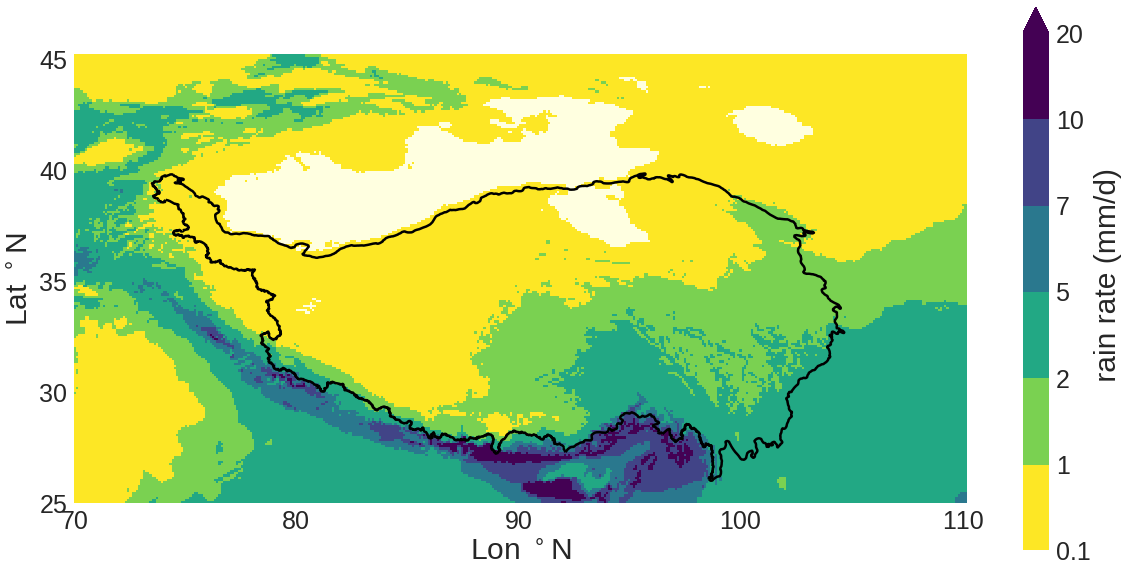

In [146]:
file= '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_daily_1979_2017.nc'
prec, lon, lat = read_in_netcdf_mswep(file)
prec= prec[0,:]

plt.figure(figsize=(20, 10))

cmap = plt.cm.get_cmap('viridis_r')
bounds= np.array([ 0.1, 1,2,  5, 7, 10, 20])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)

m = Basemap(projection='cyl', llcrnrlat=25,urcrnrlat=45.2, llcrnrlon=70, urcrnrlon=110.2,  resolution = 'c')

lon, lat =np.meshgrid(lons, lats)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec, cmap=cmap, norm = norm, vmin= 0.1, vmax = 20)
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100, 110]
ylabels= [ 25, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100, 110], xlabels, fontsize=25)
plt.yticks([25,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N', fontsize= 30)
plt.ylabel('Lat $^\circ$N', fontsize= 30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


cbar = plt.colorbar(extend= 'max')
cbar.set_label(' rain rate (mm/d)', fontsize= 30
              )
cbar.set_ticks(bounds)
labels = ['0.1','1', '2', '5', '7', '10', '20']
cbar.set_ticklabels(labels)

plt.rcParams.update({'font.size': 25})


plt.savefig('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_daily_avg_grid_1979_2018.png')


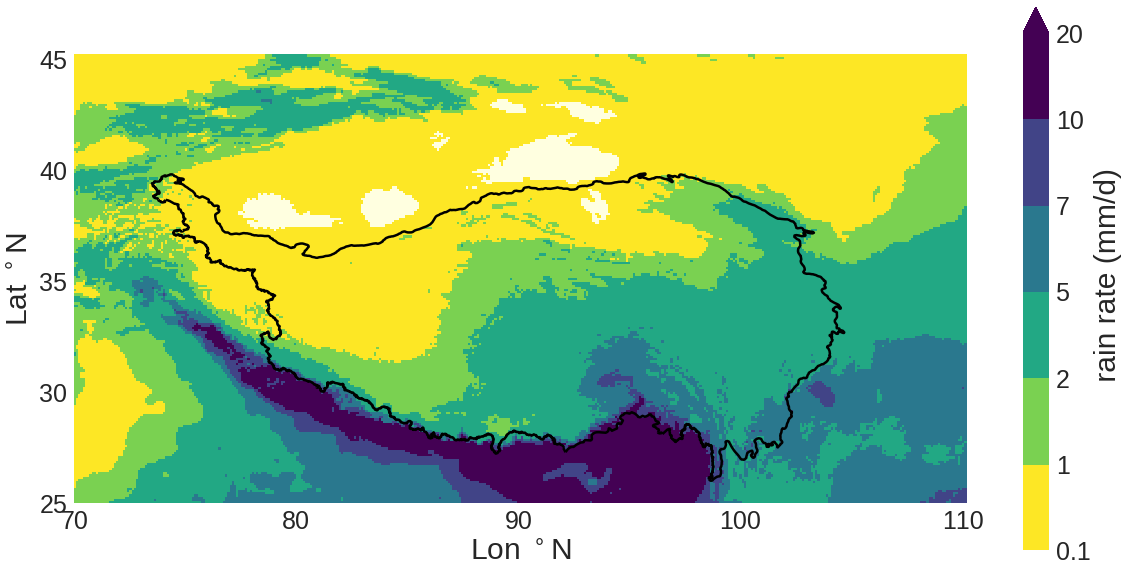

In [147]:
file= '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_summer_mean_1979_2017.nc'
prec, lon, lat = read_in_netcdf_mswep(file)
prec= prec[0,:]

plt.figure(figsize=(20, 10))
cmap = plt.cm.get_cmap('viridis_r')
bounds= np.array([ 0.1, 1,2,  5, 7, 10, 20])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)

m = Basemap(projection='cyl', llcrnrlat=25,urcrnrlat=45.2, llcrnrlon=70, urcrnrlon=110.2,  resolution = 'c')

lon, lat =np.meshgrid(lons, lats)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec, cmap=cmap, norm = norm, vmin= 0.1, vmax = 20)
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100, 110]
ylabels= [ 25, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100, 110], xlabels, fontsize=25)
plt.yticks([25,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N', fontsize= 30)
plt.ylabel('Lat $^\circ$N', fontsize= 30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


cbar = plt.colorbar(extend= 'max')
cbar.set_label(' rain rate (mm/d)', fontsize= 30
              )
cbar.set_ticks(bounds)
labels = ['0.1','1', '2', '5', '7', '10', '20']
cbar.set_ticklabels(labels)

plt.rcParams.update({'font.size': 25})


plt.savefig('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_summer_1979_2018.png')